# Import libraries (Pipeline, EDA, data processing)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
from datetime import datetime, timedelta, date
import alphalens as al

from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.filters import default_us_equity_universe_mask
from quantopian.pipeline.data.sentdex import sentiment_free as sentdex
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.zacks import EarningsSurprises


# Import libraries (preprocessing, machine learning, valuation)

In [2]:

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.cross_validation import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


# Set Parameters 

In [12]:

START = date(2005, 1, 1)

FIRST_PERIOD = 45

PERIODS_NUM = 8

price_shift = 190

days_forward = 90

missing_rate = 0.8

pca_tresh = 0.8

loss_vector = [4, 1, -1, -3, -5]

# Create Pipeline

In [4]:


MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcabike camera mountre',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

as_ = morningstar.asset_classification
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_ratios
v = morningstar.valuation
vr = morningstar.valuation_ratios

def make_pipeline():
    
    #universe = QTradableStocksUS()
    universe = (default_us_equity_universe_mask(minimum_market_cap=25000000)) 

    price = USEquityPricing.open.latest
    volume = USEquityPricing.volume.latest
    
    # Morningstar ratios
    growth_score = as_.growth_score.latest
    value_score = as_.value_score.latest
    
    # Valuation ratios
    market_cap = v.market_cap.latest/1000000
    cash_return = vr.cash_return.latest
    cf_yield = vr.cf_yield.latest
    earning_yield = vr.earning_yield.latest
    ev_to_ebitda = vr.ev_to_ebitda.latest
    pb_ratio = vr.pb_ratio.latest
    pe_ratio = vr.pe_ratio.latest
    peg_ratio = vr.peg_ratio.latest
    ps_ratio = vr.ps_ratio.latest
    pcf_ratio = vr.pcf_ratio.latest
    total_yield = vr.total_yield.latest

    # Operation ratios
    ltbe_ratio = or_.long_term_debt_equity_ratio.latest
    current_ratio = or_.current_ratio.latest
    interest_coverage = or_.interest_coverage.latest
    assets_turnover = or_.assets_turnover.latest
    cash_conversion_cycle = or_.cash_conversion_cycle.latest
    days_in_sales = or_.days_in_sales.latest
    net_income_growth = or_.net_income_growth.latest
    sales_per_employee = or_.sales_per_employee.latest
    revenue_growth = or_.revenue_growth.latest
    dps_growth = er.dps_growth.latest
    
    # Margins
    ebit_margin = or_.ebit_margin.latest
    gross_margin = or_.gross_margin.latest
    operation_margin = or_.operation_margin.latest
    net_margin = or_.net_margin.latest

    # Returns
    roa = or_.roa.latest
    roe = or_.roe.latest
    roic = or_.roic.latest
   
    # Momentum
    
    class mom_1 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=126)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-1] - prices[-252])/prices[-252] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    class mom_2 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=63)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-126])/prices[-126] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    class mom_3 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-63])/prices[-63] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    mom_test_1 = mom_1(mask = universe)
    mom_test_2 = mom_2(mask = universe)
    mom_test_3 = mom_3(mask = universe)
   
    price_mom_M = Returns(window_length=21)
    price_mom_Q = Returns(window_length=63)
    price_mom_H = Returns(window_length=126)
    price_mom_Y = Returns(window_length=252)

    # Create Pipeline
  
    pipe = Pipeline(columns = {"roa" : roa,
                               "roe":roe,
                               "roic" : roic,
                               "operation_margin" : operation_margin,
                               "ebit_margin" : ebit_margin,
                               "gross_margin" : gross_margin,
                               "net_margin" : net_margin,
                               "ltbe_ratio" : ltbe_ratio,
                               "current_ratio" : current_ratio,
                               "interest_coverage" : interest_coverage,
                               "assets_turnover" : assets_turnover,
                               "cash_conversion_cycle" : cash_conversion_cycle,
                               "days_in_sales" : days_in_sales,
                               "net_income_growth" : net_income_growth,
                               "sales_per_employee" : sales_per_employee,
                               "revenue_growth" : revenue_growth,
                               "dps_growth" : dps_growth,
                               "market_cap": market_cap,
                               "cash_return" : cash_return,
                               "cf_yield" : cf_yield,
                               "earning_yield" : earning_yield,
                               "ev_to_ebitda" : ev_to_ebitda,
                               "pb_ratio": pb_ratio,
                               "pe_ratio": pe_ratio,
                               "ps_ratio" : ps_ratio,
                               "pcf_ratio": pcf_ratio,
                               "total_yield" : total_yield,
                               "value_score" :value_score,
                               "growth_score" :growth_score,
                               "mom_test_1" : mom_test_1,
                               "mom_test_2" : mom_test_2,
                               "mom_test_3" : mom_test_3,
                               "price_mom_M" : price_mom_M,
                               "price_mom_Q" : price_mom_Q,
                               "price_mom_H" : price_mom_H,
                               "price_mom_Y" : price_mom_Y,
                               
                               "price": price,
                               "volume": volume
                              },
                   screen = universe)
    
    return pipe
    


# Define functions (time, assets, prices)

In [5]:

def time_intervals(start_year=2003, month=1, day=0):            
    years = date.today().year+1-start_year
    dates = pd.date_range(date(start_year, month=month, day=1), periods=years*4, freq='3MS')        
    dates = [date(d.date().year, d.date().month, day)  for d in dates if d.date() < date.today()]
    return dates


def get_assets(f_date, i):
    start_timer = time()

    results = run_pipeline(make_pipeline(), start_date = f_date, end_date= f_date)
    
    end_timer = time()
    print i, f_date, "Time to run pipeline %.2f secs" % (end_timer - start_timer)
    results = results[~results.index.duplicated(keep='first')]      
    results = results.loc[ results.index.get_level_values(0)[0] ]   
    return results
    
def get_prices(results, start_date):
    assets = results.index.unique()
    return get_pricing(assets,
                       start_date=start_date,
                       end_date=start_date + timedelta(days=price_shift),
                        fields = "open_price")

def assets_with_prices(date):
    results = get_assets(date)    
    print len(assets), len(results)
    prices = get_prices(results, date)
    return results, prices

def date_to_index(d):
    return QUARTERS.index(d)


def index_of_t(t):
    return (FIRST_PERIOD + PERIODS_NUM - 1) - t
 

# Define Confusion-matrix (plot)

In [6]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
 


# Define Valuation Report

In [7]:
def print_report(method, best_param, test, pred, cm, cr, prob):

    print ("GridSearch results - :", method)
    print ("Best parameters:")
    print(best_param)  
    print ('\n')
    print ("Confusion matrix:")
    print (confusion_matrix(test, pred))
    print ('\n')
    print ("Calssification Report:")
    print (classification_report(test, pred))
    print ('\n')
    print("Confusion Matrix - Validation Data:")
    print (cm)
    print ('\n')
    plot_confusion_matrix(cm, target_names = ['Bottom', 'Middle', 'Top'])
    print("Classification Report - Validation Data:")
    print(cr)
    

# Prepare "universe"

In [8]:

QUARTERS = time_intervals(START.year, START.month, START.day)

universe = []

for i in range(len(QUARTERS)):    
    current_date = QUARTERS[i]   
    df = get_assets(current_date, i)
    universe.append(df)
    

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


0 2005-01-01 Time to run pipeline 15.51 secs
1 2005-04-01 Time to run pipeline 10.57 secs
2 2005-07-01 Time to run pipeline 10.58 secs
3 2005-10-01 Time to run pipeline 9.88 secs
4 2006-01-01 Time to run pipeline 9.75 secs
5 2006-04-01 Time to run pipeline 10.54 secs
6 2006-07-01 Time to run pipeline 9.93 secs
7 2006-10-01 Time to run pipeline 9.35 secs
8 2007-01-01 Time to run pipeline 9.48 secs
9 2007-04-01 Time to run pipeline 9.32 secs
10 2007-07-01 Time to run pipeline 9.37 secs
11 2007-10-01 Time to run pipeline 10.10 secs
12 2008-01-01 Time to run pipeline 9.80 secs
13 2008-04-01 Time to run pipeline 10.47 secs
14 2008-07-01 Time to run pipeline 10.30 secs
15 2008-10-01 Time to run pipeline 10.25 secs
16 2009-01-01 Time to run pipeline 10.35 secs
17 2009-04-01 Time to run pipeline 8.34 secs
18 2009-07-01 Time to run pipeline 7.84 secs
19 2009-10-01 Time to run pipeline 7.54 secs
20 2010-01-01 Time to run pipeline 8.73 secs
21 2010-04-01 Time to run pipeline 9.07 secs
22 2010-07-

In [43]:
print "number of periods:", len(universe)


number of periods: 58


# Define Loss_Function 

In [44]:

def loss_func (cm, loss_vector):
    loss_value = (cm[0,0]*loss_vector [0] + cm[1,1]*loss_vector[1] + cm[2,2]*loss_vector[0]  +
                 cm[0,1]*loss_vector [2] + cm[0,2]*loss_vector[4] + 
                 cm[1,0]*loss_vector [3] + cm[1,2]*loss_vector[3] +
                 cm[2,0]*loss_vector [4] + cm[2,1]*loss_vector[3])
    return loss_value



# Put together "results"

In [45]:
results = universe[index_of_t(0)]
for t in range(1, PERIODS_NUM):        
    results = results.join(universe[index_of_t(t)], rsuffix='_%d' % t, how='outer')

# Put together "prices"

In [46]:
T0_DATE = QUARTERS[index_of_t(0)]
prices = get_prices(results, T0_DATE)


# Visualise "results"

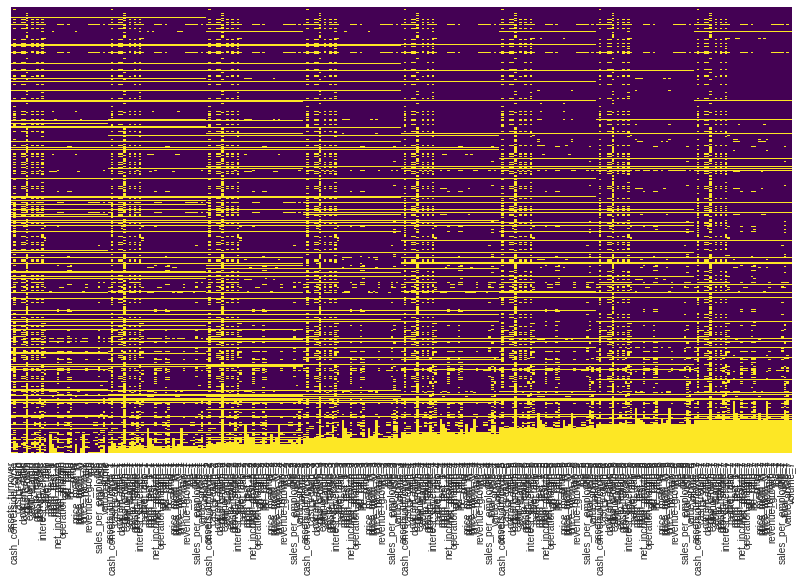

In [47]:

sns.heatmap(results.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Merge "results" and "prices"

In [48]:

result_reset = results.reset_index()

prices_shift =prices[days_forward:days_forward +1]
prices_shift = pd.DataFrame(prices_shift.stack()).reset_index()
prices_shift.drop(["level_0"], axis=1, inplace=True)

prices_shift.rename(columns ={"level_1":"index",
                              0:"P_Shift"
                              }, inplace= True)

merged_data = pd.merge(result_reset, prices_shift,on=["index"])
merged_data.head()
print (len(merged_data))

3938


# Handle missing data 

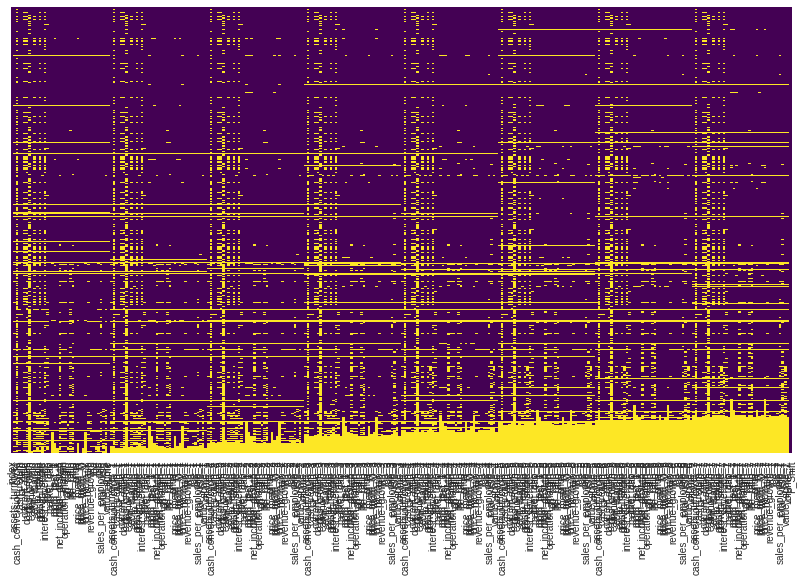

In [49]:
sns.heatmap(merged_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')


306
240
3938


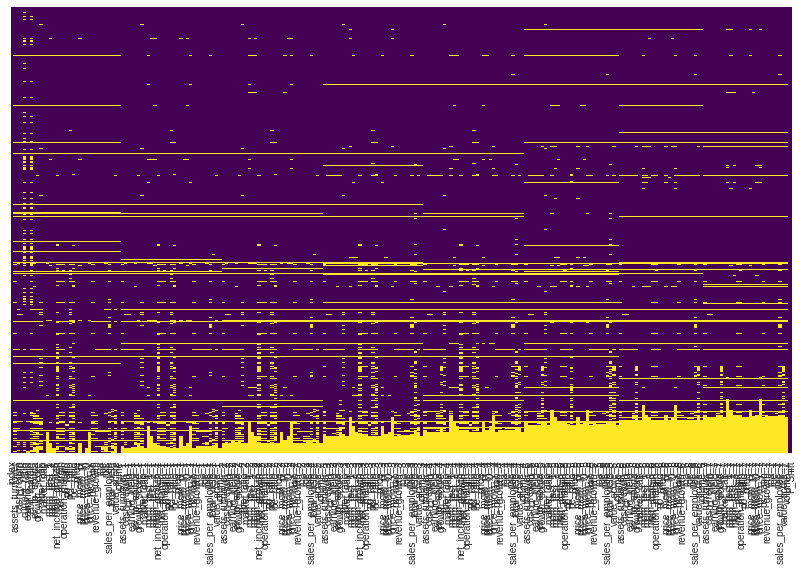

In [50]:
print(len(merged_data.columns))

thresh = len(merged_data) * missing_rate
merged_data.dropna(thresh = thresh, axis = 1, inplace = True)

print(len(merged_data.columns))

sns.heatmap(merged_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

print (len(merged_data))

3938
3213


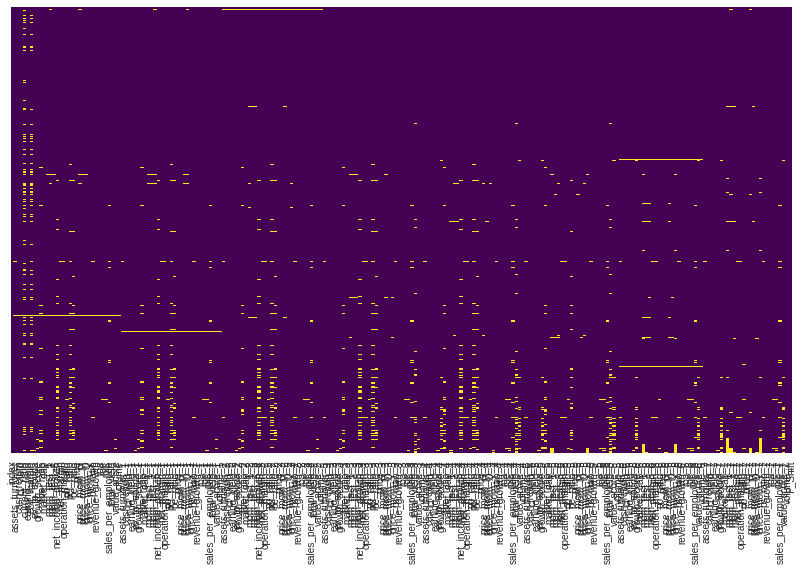

In [51]:
print(len(merged_data))
thresh = len(merged_data.columns) * missing_rate

merged_data.dropna(thresh = thresh, axis = 0, inplace= True)
print (len (merged_data))

sns.heatmap(merged_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

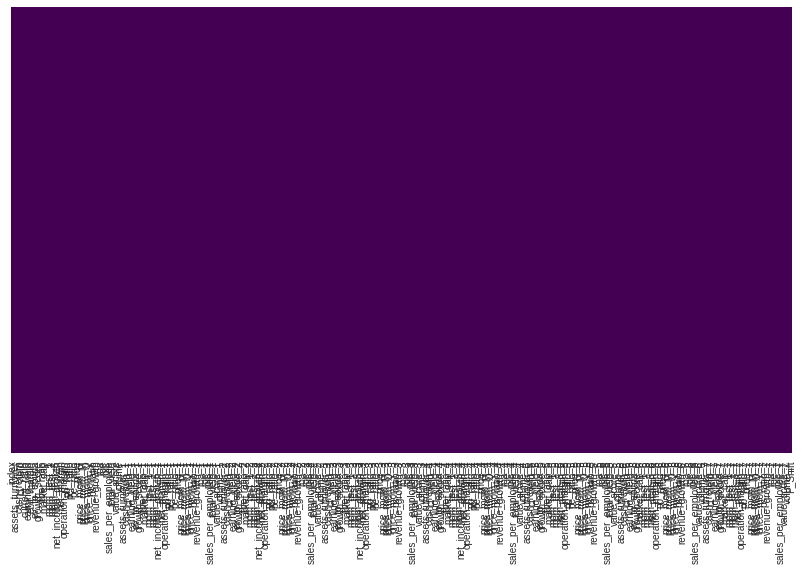

In [52]:
def column_of_t(name, t):
    if t == 0:
        return name
    else:
        return name+'_%d' % t
    
def columns_of(name):
    names = []
    for i in range(PERIODS_NUM):
        names.append(column_of_t(name, i))
    return names

for column in universe[0].columns:
        current_columns = columns_of(column)
        existing_columns = merged_data.columns & set(current_columns)
        
        merged_data[existing_columns] = merged_data[existing_columns].fillna(method='bfill', axis=1)
        merged_data[existing_columns] = merged_data[existing_columns].fillna(method='ffill', axis=1)
        
        for ec in existing_columns:
            merged_data[ec] = merged_data[ec].fillna(merged_data[ec].mean())
            
sns.heatmap(merged_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Prepare "CLASS" column (Target Variable)

In [53]:
merged_data["Return"] = (merged_data["P_Shift"] - merged_data["price"]) / merged_data["price"]
merged_data["Rank_Ret"] = merged_data["Return"].rank()

merged_data['CLASS'] = merged_data['Rank_Ret'].apply(lambda x: 
                                   "Top" if x > len(merged_data)*2/3 
                                    else "Mid" if x >= len(merged_data)*1/3
                                    else "Bot")


print (len(merged_data))

merged_data.groupby("CLASS").describe()


3213


P_Shift     Rank_Ret       Return  assets_turnover  \
CLASS                                                                 
Bot   count  1070.000000  1070.000000  1070.000000      1070.000000   
      mean     35.836874   535.500000    -0.203646         0.226573   
      std     103.413452   309.026697     0.130465         0.258156   
      min       0.160000     1.000000    -0.891282         0.000005   
      25%       6.244750   268.250000    -0.257922         0.056650   
      50%      18.640000   535.500000    -0.164377         0.172615   
      75%      40.637500   802.750000    -0.108711         0.317739   
      max    3014.000000  1070.000000    -0.070467         4.349152   
Mid   count  1072.000000  1072.000000  1072.000000      1072.000000   
      mean     58.161950  1606.500000    -0.004049         0.159412   
      std     147.149112   309.604032     0.038769         0.273613   
      min       0.359000  1071.000000    -0.070455         0.000002   
      25%      15.626000  1338.750000    -0.035378         0.022831   
      50%      33.822000  1606.500000    -0.006097         0.101213   
      75%      66.086750  1874.250000     0.028379         0.221804   
      max    4045.000000  2142.000000     0.068000         7.120448   
Top   count  1071.000000  1071.000000  1071.000000      1071.000000   
      mean     56.574189  2678.000000     0.317419         0.215843   
      std     101.082158   309.315372     0.560682         0.578955   
      min       1.150000  2143.000000     0.068164         0.000018   
      25%      13.150000  2410.500000     0.122782         0.063088   
      50%      32.759000  2678.000000     0.191928         0.162696   
      75%      67.726500  2945.500000     0.341718         0.274408   
      max    2092.320000  3213.000000    10.160000        18.088294   

             assets_turnover_1  assets_turnover_2  assets_turnover_3  \
CLASS                                                                  
Bot   count        1070.000000        1070.000000        1070.000000   
      mean            0.223195           0.217406           0.225462   
      std             0.234489           0.238936           0.255529   
      min             0.000005           0.000005           0.000005   
      25%             0.056277           0.052409           0.054164   
      50%             0.167081           0.162041           0.164000   
      75%             0.315374           0.299923           0.309233   
      max             2.670062           3.265779           4.167239   
Mid   count        1072.000000        1072.000000        1072.000000   
      mean            0.162446           0.160500           0.163996   
      std             0.310579           0.358381           0.318567   
      min             0.000002           0.000004           0.000007   
      25%             0.022901           0.022365           0.023103   
      50%             0.102260           0.102342           0.104293   
      75%             0.219753           0.213849           0.222539   
      max             8.575042          10.493292           8.874346   
Top   count        1071.000000        1071.000000        1071.000000   
      mean            0.221753           0.216314           0.216032   
      std             0.741817           0.674416           0.482483   
      min             0.000009           0.000009           0.000009   
      25%             0.062990           0.060528           0.061407   
      50%             0.163505           0.159694           0.165728   
      75%             0.272184           0.273041           0.285138   
      max            23.674950          21.387755          14.683607   

             assets_turnover_4  assets_turnover_5  assets_turnover_6  \
CLASS                                                                  
Bot   count        1070.000000        1070.000000        1070.000000   
      mean            0.224906           0.225142           0.216103   
      std

#Building ML


## Prepare data for Classification

In [54]:

merged_data = merged_data.drop([ "index","P_Shift", "Return", "Rank_Ret"], axis = 1)
merged_data.info()

df_X = merged_data.drop("CLASS", axis = 1)
df_X.info()
df_X.describe()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3643
Columns: 239 entries, assets_turnover to CLASS
dtypes: float64(238), object(1)
memory usage: 5.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3643
Columns: 238 entries, assets_turnover to volume_7
dtypes: float64(238)
memory usage: 5.9 MB


,assets_turnover,cash_return,cf_yield,current_ratio,earning_yield,ebit_margin,ev_to_ebitda,growth_score,ltbe_ratio,market_cap,...,price_mom_Q_7,price_mom_Y_7,ps_ratio_7,revenue_growth_7,roa_7,roe_7,roic_7,sales_per_employee_7,value_score_7,volume_7
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,...,3213.000000,3213.000000,3.213000e+03,3213.000000,3213.000000,3213.000000,3213.000000,3.213000e+03,3213.000000,3.213000e+03
mean,0.200588,-0.012630,0.059342,3.657472,-0.023813,43.502552,26.210104,52.452352,4.786026,9240.058697,...,-0.007693,-0.073438,8.197476e+03,0.360577,-0.003689,-0.132374,-0.002718,5.147988e+05,46.962686,9.700871e+05
std,0.399588,1.305252,0.358185,30.465091,1.662062,3775.608349,225.611575,23.012743,55.368579,37784.588490,...,0.217607,0.324120,4.534526e+05,4.108184,0.337875,4.759054,0.610068,6.663211e+06,22.648844,2.799198e+06
min,0.000002,-69.367300,-11.755700,0.014134,-36.996000,-43342.468293,-5038.130600,0.000000,0.000005,25.005599,...,-0.803244,-0.903365,4.164000e-03,-0.982707,-10.230705,-256.628713,-13.960424,9.318182e+00,0.124330,1.000000e+02
25%,0.041126,-0.000900,0.028700,1.341649,-0.013200,0.010128,7.920800,37.933640,0.195043,333.049239,...,-0.109264,-0.274658,8.670860e-01,-0.061592,-0.006586,-0.020097,-0.007426,4.906789e+04,28.940930,6.494300e+04
50%,0.145324,0.030100,0.062300,2.281271,0.031000,0.103706,12.199900,52.736600,0.610278,1326.623605,...,-0.008325,-0.062834,1.938493e+00,0.029278,0.004212,0.017901,0.013234,8.062025e+04,46.962686,2.376830e+05
75%,0.269250,0.061300,0.102200,3.657472,0.051100,0.269588,18.681900,68.765700,1.401471,4801.845333,...,0.092278,0.107678,3.958180e+00,0.149431,0.016269,0.039107,0.026856,1.762500e+05,64.541740,8.000980e+05
max,18.088294,8.980300,9.520800,1708.266245,81.987700,208177.750727,5373.396800,100.000330,2118.538462,860882.486880,...,4.045455,2.649116,2.570228e+07,132.859873,15.013972,41.666667,20.707502,2.650000e+08,99.360250,6.919632e+07


## Standardisation

In [55]:
names = df_X.columns
scaler = preprocessing.StandardScaler()
df_X = scaler.fit_transform(df_X)
df_X = pd.DataFrame(df_X, columns=names)
len(df_X)

3213

## PCA - plot

In [59]:
n_componance = 1
explained_var = []

for i in range(len(df_X.columns)):
    pca = PCA(n_components=n_componance)
    n_componance +=1
    pca.fit_transform(df_X)
    explain= sum(pca.explained_variance_ratio_)
    explained_var.append(explain)
    

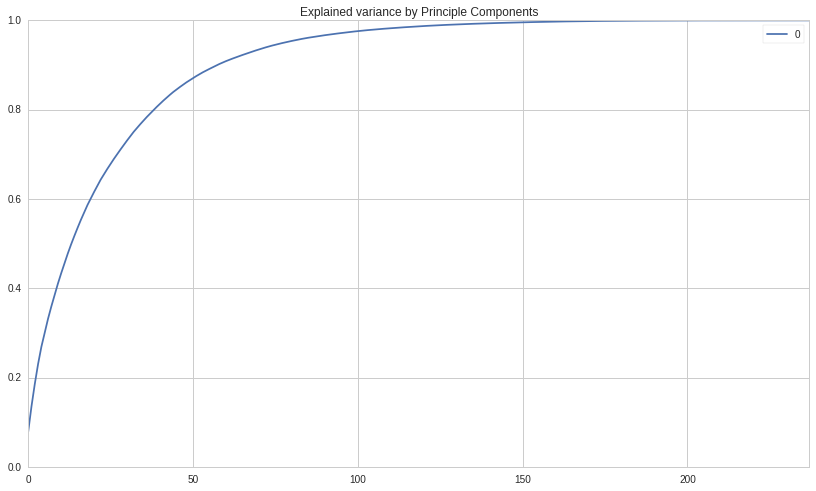

In [60]:
explained_var_plot = pd.DataFrame(explained_var)
explained_var_plot.plot(title= "Explained variance by Principle Components")

## PCA - number of components

In [61]:
n_pca = 1

for i in range (len (explained_var)):
    if explained_var [i] < pca_tresh:
        n_pca  +=1
        i +=1
    else:
        i+=1

print ("Number of PC-s. ", n_pca)

pca = PCA(n_components = n_pca)
principalDf = pd.DataFrame(pca.fit_transform(df_X))

print ("Variance explained by PCA: ", sum(pca.explained_variance_ratio_))
len(principalDf)

('Number of PC-s. ', 40)
('Variance explained by PCA: ', 0.80627305924715753)


3213

## Split - Train /Validation

In [62]:
X_train, X_val, y_train, y_val = train_test_split(principalDf,
                                                  merged_data["CLASS"], test_size=0.2, random_state=101)



## Split - cross-validation

In [63]:

X = np.array(X_train)
print(len(X))
y = np.array(y_train)
print(len(y))

skf = StratifiedKFold (y, n_folds=5,  random_state= 1)
for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

2570
2570


In [64]:
print(len(X_train))
print(len(X_test))
print (len(y_train))
print(len(y_test))


2057
513
2057
513


# Model Selection - GridSearch

# Calculate Models

## K-nearest neighbors

In [75]:

def knn():
    start_timer = time()
    global knn_cm, knn_prob
    classifier = KNeighborsClassifier()  

    grid_param = {  
        'n_neighbors': [25,39, 55],
        'weights': ['uniform', "distance"],
        'algorithm': ["ball_tree", "kd_tree", "auto"]
    }

    knn_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv = 5,
                         n_jobs=-1)

    knn_grid.fit(X_train, y_train)  
    knn_pred = knn_grid.predict(X_test)
    best_parameters = knn_grid.best_params_  


    knn_val = knn_grid.predict(X_val)
    knn_cm = confusion_matrix(y_val, knn_val)
    knn_cr = classification_report(y_val, knn_val)
    knn_prob = knn_grid.predict_proba(X_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    
    print_report(method = "KNN",
                best_param = best_parameters,
                test = y_test,
                pred = knn_pred,
                cm = knn_cm,
                cr = knn_cr,
                prob = knn_prob)
    
    
    return 
    
    

## Random forest

In [76]:
def rfc():

    start_timer = time()
    
    global rfc_cm, rfc_prob
    classifier = RandomForestClassifier()  

    grid_param = {  
        'n_estimators': [10, 100, 1000],
        'criterion': ['gini'],
        'bootstrap': [True, False]
    }

    rfc_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv = 5,
                         n_jobs=-1)

    rfc_grid.fit(X_train, y_train)  
    rfc_pred = rfc_grid.predict(X_test)
    best_parameters = rfc_grid.best_params_  

    rfc_val = rfc_grid.predict(X_val)
    rfc_cm = confusion_matrix(y_val, rfc_val)
    rfc_cr = classification_report(y_val, rfc_val)
    rfc_prob = rfc_grid.predict_proba(X_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)

    print_report(method = "RFC",
                best_param = best_parameters,
                test = y_test,
                pred = rfc_pred,
                cm = rfc_cm,
                cr = rfc_cr,
                prob = rfc_prob)
    
    return 



## Support vector classifier

In [77]:

def svc():
    start_timer = time()

    global svc_cm, svc_prob
    classifier = SVC(probability=True)  

    grid_param = {  
        'C': [ 0.1, 1],
        'kernel': ['rbf', "linear"]
    }

    svc_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv = 5,
                         n_jobs=-1)

    svc_grid.fit(X_train, y_train)  
    svc_pred = svc_grid.predict(X_test)
    best_parameters = svc_grid.best_params_  

    svc_val = svc_grid.predict(X_val)
    svc_cm = confusion_matrix(y_val, svc_val)
    svc_cr = classification_report(y_val, svc_val)
    svc_prob = svc_grid.predict_proba(X_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)

    print_report(method = "SVC",
                best_param = best_parameters,
                test = y_test,
                pred = svc_pred,
                cm = svc_cm,
                cr = svc_cr,
                prob = svc_prob)
    
    return 




## Logistic Regression

In [78]:
def lgm ():
    start_timer = time()

    global lgm_cm, lgm_prob
    classifier = LogisticRegression()  

    grid_param = {  
        'penalty': ['l1', "l2"],
        'C': [0.01, 0.1, 1],
        'solver': ['newton-cg', 'lbfgs', "liblinear"],
        'verbose': [1]
    }

    lgm_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv = 5,
                         n_jobs=-1)

    lgm_grid.fit(X_train, y_train)  
    lgm_pred = lgm_grid.predict(X_test)
    best_parameters = lgm_grid.best_params_  

    lgm_val = lgm_grid.predict(X_val)
    lgm_cm = confusion_matrix(y_val, lgm_val)
    lgm_cr = classification_report(y_val, lgm_val)
    lgm_prob = lgm_grid.predict_proba(X_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    
    print_report(method = "LGM",
            best_param = best_parameters,
            test = y_test,
            pred = lgm_pred,
            cm = lgm_cm,
            cr = lgm_cr,
            prob = lgm_prob)
    
    return 



# Gradient boosting

In [79]:

def gbm():
    
    start_timer = time()
    
    global gbm_cm, gbm_prob
    classifier = GradientBoostingClassifier()  
    grid_param = {  
        'loss': ['deviance'],
        'learning_rate': [0.001, 0.01],
        'n_estimators': [100, 1000],
        'max_depth': [1, 3],
        'max_features':['auto']
    }

    gbm_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv = 5,
                         n_jobs=-1)

    gbm_grid.fit(X_train, y_train)  
    gbm_pred = gbm_grid.predict(X_test)
    best_parameters = gbm_grid.best_params_  

    gbm_val = gbm_grid.predict(X_val)
    gbm_cm = confusion_matrix(y_val, gbm_val)
    gbm_cr = classification_report(y_val, gbm_val)
    gbm_prob = gbm_grid.predict_proba(X_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)

    print_report(method = "GBM",
                best_param = best_parameters,
                test = y_test,
                pred = gbm_pred,
                cm = gbm_cm,
                cr = gbm_cr,
                prob = gbm_prob)

    return 



# Gaussian naive bayes

In [80]:

def gnb():
    start_timer = time()

    global gnb_cm, gnb_prob
    classifier =  GaussianNB ()

    grid_param = {  
       }

    gnb_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv = 5,
                         n_jobs=-1)

    gnb_grid.fit(X_train, y_train)  
    gnb_pred = gnb_grid.predict(X_test)
    best_parameters = gnb_grid.best_params_  

    gnb_val = gnb_grid.predict(X_val)
    gnb_cm = confusion_matrix(y_val, gnb_val)
    gnb_cr = classification_report(y_val, gnb_val)
    gnb_prob = gnb_grid.predict_proba(X_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)

    print_report(method = "GNB",
                best_param = best_parameters,
                test = y_test,
                pred = gnb_pred,
                cm = gnb_cm,
                cr = gnb_cr,
                prob = gnb_prob)

    return



# LOSS Function

In [81]:
loss_models = []

def run_ML ():
    knn()
    svc()
    lgm()
    rfc()
    gbm()
    gnb()
    loss_models.append({"Method": "knn", "Value": loss_func(knn_cm, loss_vector)})
    loss_models.append({"Method":"svc", "Value": loss_func(svc_cm, loss_vector)})
    loss_models.append({"Method":"lgm", "Value": loss_func(lgm_cm, loss_vector)})
    loss_models.append({"Method":"rfc", "Value": loss_func(rfc_cm, loss_vector)})
    loss_models.append({"Method":"gbm", "Value": loss_func(gbm_cm, loss_vector)})
    loss_models.append({"Method":"gnb", "Value": loss_func(gnb_cm, loss_vector)})

    best_method = sorted(loss_models, key = lambda i: i["Value"], reverse=True)[0]["Method"]
    print ("Method to apply:  =  ",  best_method)
    

Time to create model 5.32 secs
('GridSearch results - :', 'KNN')
Best parameters:
{'n_neighbors': 55, 'weights': 'uniform', 'algorithm': 'ball_tree'}


Confusion matrix:
[[ 58  78  35]
 [ 34 102  34]
 [ 37  82  53]]


Calssification Report:
             precision    recall  f1-score   support

        Bot       0.45      0.34      0.39       171
        Mid       0.39      0.60      0.47       170
        Top       0.43      0.31      0.36       172

avg / total       0.42      0.42      0.41       513



Confusion Matrix - Validation Data:
[[ 65  96  51]
 [ 31 160  30]
 [ 40  86  84]]




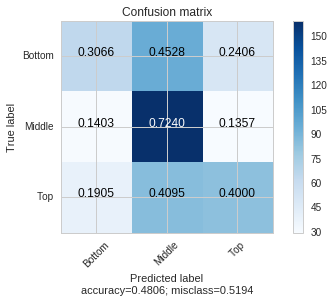

Classification Report - Validation Data:
             precision    recall  f1-score   support

        Bot       0.48      0.31      0.37       212
        Mid       0.47      0.72      0.57       221
        Top       0.51      0.40      0.45       210

avg / total       0.48      0.48      0.46       643

Time to create model 58.67 secs
('GridSearch results - :', 'SVC')
Best parameters:
{'kernel': 'rbf', 'C': 0.1}


Confusion matrix:
[[109  35  27]
 [ 68  69  33]
 [ 80  39  53]]


Calssification Report:
             precision    recall  f1-score   support

        Bot       0.42      0.64      0.51       171
        Mid       0.48      0.41      0.44       170
        Top       0.47      0.31      0.37       172

avg / total       0.46      0.45      0.44       513



Confusion Matrix - Validation Data:
[[133  48  31]
 [ 96  96  29]
 [107  42  61]]




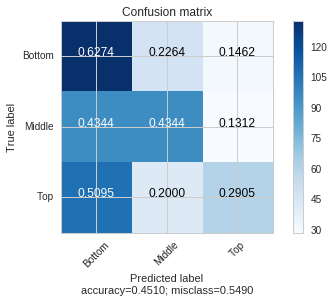

Classification Report - Validation Data:
             precision    recall  f1-score   support

        Bot       0.40      0.63      0.49       212
        Mid       0.52      0.43      0.47       221
        Top       0.50      0.29      0.37       210

avg / total       0.47      0.45      0.44       643

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 14.84 secs
('GridSearch results - :', 'LGM')
Best parameters:
{'penalty': 'l2', 'C': 0.01, 'verbose': 1, 'solver': 'liblinear'}


Confusion matrix:
[[63 56 52]
 [32 92 46]
 [50 47 75]]


Calssification Report:
             precision    recall  f1-score   support

        Bot       0.43      0.37      0.40       171
        Mid 

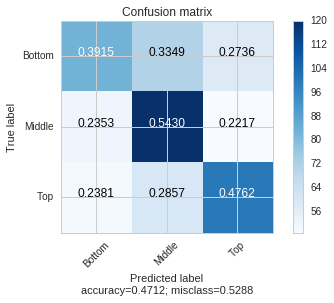

Classification Report - Validation Data:
             precision    recall  f1-score   support

        Bot       0.45      0.39      0.42       212
        Mid       0.48      0.54      0.51       221
        Top       0.48      0.48      0.48       210

avg / total       0.47      0.47      0.47       643

Time to create model 105.32 secs
('GridSearch results - :', 'RFC')
Best parameters:
{'n_estimators': 1000, 'bootstrap': True, 'criterion': 'gini'}


Confusion matrix:
[[90 38 43]
 [47 79 44]
 [49 49 74]]


Calssification Report:
             precision    recall  f1-score   support

        Bot       0.48      0.53      0.50       171
        Mid       0.48      0.46      0.47       170
        Top       0.46      0.43      0.44       172

avg / total       0.47      0.47      0.47       513



Confusion Matrix - Validation Data:
[[ 99  61  52]
 [ 61 111  49]
 [ 61  59  90]]




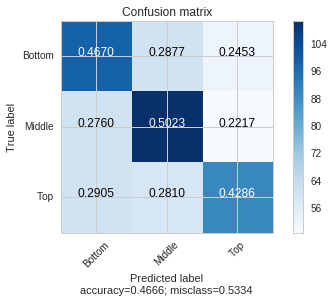

Classification Report - Validation Data:
             precision    recall  f1-score   support

        Bot       0.45      0.47      0.46       212
        Mid       0.48      0.50      0.49       221
        Top       0.47      0.43      0.45       210

avg / total       0.47      0.47      0.47       643

Time to create model 127.23 secs
('GridSearch results - :', 'GBM')
Best parameters:
{'max_features': 'auto', 'loss': 'deviance', 'learning_rate': 0.001, 'n_estimators': 1000, 'max_depth': 3}


Confusion matrix:
[[80 55 36]
 [46 88 36]
 [54 51 67]]


Calssification Report:
             precision    recall  f1-score   support

        Bot       0.44      0.47      0.46       171
        Mid       0.45      0.52      0.48       170
        Top       0.48      0.39      0.43       172

avg / total       0.46      0.46      0.46       513



Confusion Matrix - Validation Data:
[[ 93  74  45]
 [ 60 127  34]
 [ 67  58  85]]




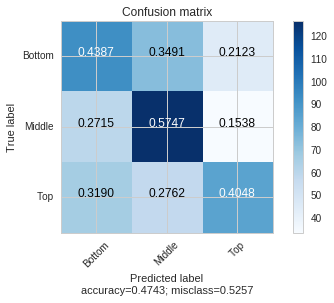

Classification Report - Validation Data:
             precision    recall  f1-score   support

        Bot       0.42      0.44      0.43       212
        Mid       0.49      0.57      0.53       221
        Top       0.52      0.40      0.45       210

avg / total       0.48      0.47      0.47       643

Time to create model 0.03 secs
('GridSearch results - :', 'GNB')
Best parameters:
{}


Confusion matrix:
[[ 11   2 158]
 [  8   6 156]
 [ 10   5 157]]


Calssification Report:
             precision    recall  f1-score   support

        Bot       0.38      0.06      0.11       171
        Mid       0.46      0.04      0.07       170
        Top       0.33      0.91      0.49       172

avg / total       0.39      0.34      0.22       513



Confusion Matrix - Validation Data:
[[ 13   9 190]
 [ 10   7 204]
 [ 15   4 191]]




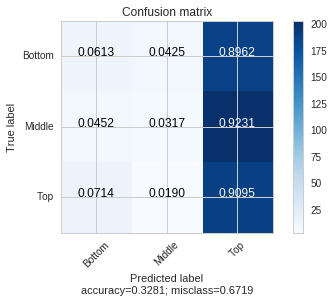

Classification Report - Validation Data:
             precision    recall  f1-score   support

        Bot       0.34      0.06      0.10       212
        Mid       0.35      0.03      0.06       221
        Top       0.33      0.91      0.48       210

avg / total       0.34      0.33      0.21       643

('Method to apply:  =  ', 'knn')


In [82]:
run_ML()

In [83]:

loss_models = []
loss_models.append({"Method": "knn", "Value": loss_func(knn_cm, loss_vector)})
loss_models.append({"Method":"svc", "Value": loss_func(svc_cm, loss_vector)})
loss_models.append({"Method":"lgm", "Value": loss_func(lgm_cm, loss_vector)})
loss_models.append({"Method":"rfc", "Value": loss_func(rfc_cm, loss_vector)})
loss_models.append({"Method":"gbm", "Value": loss_func(gbm_cm, loss_vector)})
loss_models.append({"Method":"gnb", "Value": loss_func(gnb_cm, loss_vector)})

sorted(loss_models, key = lambda i: i["Value"], reverse=True)


[{'Method': 'knn', 'Value': -236},
 {'Method': 'lgm', 'Value': -242},
 {'Method': 'gbm', 'Value': -251},
 {'Method': 'rfc', 'Value': -266},
 {'Method': 'svc', 'Value': -367},
 {'Method': 'gnb', 'Value': -865}]

In [84]:
best_method = sorted(loss_models, key = lambda i: i["Value"], reverse=True)[0]["Method"]
print ("Method to apply:  =  ",  best_method)



('Method to apply:  =  ', 'knn')
